<a href="https://colab.research.google.com/github/nicholassung97/EvoJaxforPINNs/blob/main/Adapting_to_PINNs_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install evojax
!pip install flax
!pip install evosax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 249 kB 53.9 MB/s 
     |████████████████████████████████| 180 kB 66.4 MB/s 
     |████████████████████████████████| 145 kB 64.5 MB/s 
     |████████████████████████████████| 217 kB 70.5 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 5.6 MB/s 


In [2]:
import os
import numpy as np
import jax
import shutil
import jax.numpy as jnp
import logging
import time
import matplotlib.pyplot as plt
from jax import random, grad, vmap, hessian, jacfwd
from evojax import Trainer
from evojax.task.base import TaskState
from evojax.task.base import VectorizedTask
from evojax.policy.base import PolicyNetwork
from evojax.policy.base import PolicyState
from evojax.util import create_logger
from evojax.util import get_params_format_fn
from flax.struct import dataclass
from typing import Tuple
from flax import linen as nn
from jax.nn.initializers import xavier_uniform
from evojax.sim_mgr import SimManager
from flax.core.frozen_dict import unfreeze, freeze


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory to save logs and models

In [4]:
# Let's create a directory to save logs and models.
log_dir = '/content/drive/My Drive/IHPC RA/EvoJax/EvoJax(PINNs)/CMA soln'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('EvoJax for PINNs')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

Tesla T4


# Functions

In [5]:
@dataclass
# Contains the train input and its labels
class State(TaskState):
    obs: jnp.ndarray
    labels: jnp.ndarray
# Function to generate analytical solution
def eval_u(x, Pe, L):
    u = (1. - jax.numpy.exp(Pe*x/L)) / (1. - jax.numpy.exp(Pe))
    return u

def eval_Pe(u, k, L):
    return u*L/k

# f: IC/BC
def tf_bc(x):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

# # define sampling plan
# def sample_batch(key, data_pde, labels_pde, data_bc, labels_bc, batch_size):

#     idx = jax.random.choice(
#         key=key, a=data_pde.shape[0], shape=(batch_size,), replace=False)
#     batch_data_pde = jnp.take(data_pde, indices=idx, axis=0)
#     batch_labels_pde = jnp.take(labels_pde, indices=idx, axis=0)
#     batch_data = jax.numpy.vstack([batch_data_pde, data_bc])
#     labels_data = jax.numpy.vstack([batch_labels_pde, labels_bc])
#     return batch_data, labels_data

In [6]:
# We prepare the data
# choose v (PDE parameter)
v = 10.
# fixed PDE & BC parameters k & L
k = 1.
L = 1.
Pe = eval_Pe(v, k, L)
lmbda = 500
# Domain Boundary
x_l, x_u = 0, L
n = 1000


In [7]:
# Loss Function will be used as the fitness  (f=-L)
def loss(prediction, input, target):
  # essentially the new prediction here
    x= input[:,0:1].reshape(-1,1)
    u, u_x, u_xx = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3]
    # ground truth
    t_u = tf_bc(x)  
    _bc = jnp.where((jnp.equal(x, x_l)|jnp.equal(x, x_u)), 1, 0)
    # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
    bc_mse = jnp.sum(jnp.square((t_u-u)*_bc))/jnp.sum(_bc)
    # PDE (physics laws): v*u_x = k*u_xx  
    pde = v*u_x - k*u_xx 
    # exclude BC points
    _pde = jnp.where((jnp.equal(x, x_l)|jnp.equal(x, x_u)), 0, 1)
    pde = pde*_pde
    pde_mse = jnp.sum(jnp.square(pde))/jnp.sum(_pde)
    pde_mse = pde_mse / lmbda  
    loss = pde_mse + bc_mse
    return loss

# Accuracy should not be used in this case, change to mean square error
def mse(prediction, target):
    u = prediction[:,0:1]
    mean_square_error = jnp.mean(jnp.square(u-target)) 
    return mean_square_error

# Task

In [8]:
class Diffusion(VectorizedTask):
    """PDE-NN for 1D convection-diffusion equation.
    We model the regression as a one-step task, i.e., 
    `Diffusion.reset` returns a batch of data to the agent, the agent outputs
    predictions, `Diffusion.step` returns the reward loss) and
    terminates the rollout.
    """

    def __init__(self, batch_size, test):

        self.max_steps = 1

        # These are similar to OpenAI Gym environment's
        # observation_space and action_space.
        # They are helpful for initializing the policy networks.
        # Input shape is 2
        self.obs_shape = tuple([2, ])
        # Output shape is 1
        self.act_shape = tuple([1, ])


        x = jnp.linspace(x_l, x_u, n)
        # PDE Data
        data_pde = jnp.hstack([x.reshape(-1, 1), np.ones((len(x), 1))])
        # samples, features = data_pde.shape
        labels_pde = np.reshape(eval_u(x, Pe, L),(-1, 1))
        # # BC data
        # bc = jnp.where((data_pde[:,0] == x_l) | (data_pde[:,0] == x_u))[0]
        # data_bc = jnp.take(data_pde, indices=bc, axis=0)
        # labels_bc = jnp.take(labels_pde, indices=bc, axis=0)

        def reset_fn(key):
            batch_data, batch_labels = data_pde, labels_pde
            # if test:
            #     # In the test mode, we want to test on the entire test set.
            #     batch_data, batch_labels = data_pde, labels_pde
            # else:
            #     # In the training mode, we only sample a batch of training data.
            #     batch_data, batch_labels = sample_batch(
            #         key, data_pde, labels_pde, data_bc, labels_bc, batch_size)
            return State(obs=batch_data, labels=batch_labels)
        
        # We use jax.vmap for auto-vectorization.
        self._reset_fn = jax.jit(jax.vmap(reset_fn))
        
        # step_fn needs to be changed
        def step_fn(state, action):
            if test:
                # In the test mode, we report the mean square error
                "change to training loss"
                # reward = loss(action, state.obs, state.labels)
                reward = mse(action, state.labels)
            else:
                # In the training mode, we return the negative loss as the
                # fitness. 
                # the action (prediction) will include u, u_x and u_xx
                reward = -loss(action, state.obs, state.labels)
            # This is an one-step task, so that last return value (the `done`
            # flag) is one.
            
            return state, reward, jnp.ones(())

        # We use jax.vmap for auto-vectorization.
        self._step_fn = jax.jit(jax.vmap(step_fn))
    # Returns a batch of data to the agent, the agent outputs predictions
    def reset(self, key):
        return self._reset_fn(key)
    # Returns the fitness loss
    def step(self, state, action):
        return self._step_fn(state, action)

In [9]:
seed = 42  # Wish me luck!
batch_size = 498
train_task = Diffusion(batch_size=batch_size, test=False)
test_task = Diffusion(batch_size=batch_size, test=True)

# Policy

In [10]:
class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    self.layers = [nn.Dense(10, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(10, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(10, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      x, w = inputs[:,0:1], inputs[:,1:2]
      
      def get_u(x,w):
        u = jnp.hstack([x,w])
        for i, lyr in enumerate(self.layers):
          u = lyr(u)
        return u

      u = get_u(x, w)

      # obtain u_x
      def get_u_x(get_u, x, w):
        u_x = jacfwd(get_u)(x, w)
        return u_x
      u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
      u_x = u_x_vmap(get_u, x, w).reshape(-1,1)  
      #obtain u_xx    
      def get_u_xx(get_u, x, w):
        u_xx = hessian(get_u)(x,w)
        return u_xx
      u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
      u_xx = u_xx_vmap(get_u, x, w).reshape(-1,1)      
      action = jnp.hstack([u,u_x, u_xx])   
      return action


In [11]:
class PINNsPolicy(PolicyNetwork):
    """A physics informmed neural neural network for the diffusion task."""

    def __init__(self, logger: logging.Logger = None):
        if logger is None:
            self._logger = create_logger('PINNsPolicy')
        else:
            self._logger = logger

        model = PINNs()
        params = model.init(random.PRNGKey(0), jnp.zeros([1,2]))
        """Return a function that formats the parameters into a correct format."""
        self.num_params, format_params_fn = get_params_format_fn(params)
        self._logger.info(
            'PINNsPolicy.num_params = {}'.format(self.num_params))
        self._format_params_fn = jax.vmap(format_params_fn)
        self._forward_fn = jax.vmap(model.apply)

    def get_actions(self,
                    t_states: TaskState,
                    params: jnp.ndarray,
                    p_states: PolicyState) -> Tuple[jnp.ndarray, PolicyState]:
        params = self._format_params_fn(params)
        return self._forward_fn(params, t_states.obs), p_states
policy = PINNsPolicy(logger=logger)

# Solvers

PGPE Solver

In [12]:
# from evojax.algo import PGPE

# # # need to change to the cma code developed by the evojax team - how to call on the cma-es code 
# popn =64
# solver = PGPE(
#     pop_size=popn,
#     param_size=policy.num_params,
#     optimizer='adam',
#     center_learning_rate=0.05,
#     seed=seed,
# )
# trainer = Trainer(
#     policy=policy,
#     solver=solver,
#     train_task=train_task,
#     test_task=test_task,
#     max_iter=1000,
#     log_interval=100,
#     test_interval=200,
#     n_repeats=5,
#     n_evaluations=128,
#     seed=seed,
#     log_dir=log_dir,
#     logger=logger,
# )
# _ = trainer.run()

CMA-ES Wrapper Solver

In [15]:
# from evojax.algo import CMA
# popn =64
# solver = CMA(
#             pop_size=popn,
#             param_size=policy.num_params,
#             init_stdev=0.05,
#             seed=seed,
#             logger=logger,
#         )

CMA-ES Jax Solver

In [19]:
from evojax.algo import CMA_ES_JAX

"""Initialization.
Args:
    policy - The policy network to use.
    solver - The ES algorithm for optimization.
    train_task - The task for training.
    test_task - The task for evaluation.
    max_iter - Maximum number of training iterations.
    log_interval - Interval for logging.
    test_interval - Interval for tests.
    n_repeats - Number of rollout repetitions.
    n_evaluations - Number of tests to conduct.
    seed - Random seed to use.
    log_dir - Directory to dump logs.
    logger - Logger.
"""
popn = 64

solver = CMA_ES_JAX(
                pop_size=popn,
                param_size=policy.num_params,
                init_stdev=0.05,
                seed=seed,
                logger=logger)
# trainer = Trainer(
#     policy=policy,
#     solver=solver,
#     train_task=train_task,
#     test_task=test_task,
#     max_iter=2000,
#     log_interval=100,
#     test_interval=200,
#     n_repeats=1,
#     n_evaluations=128,
#     seed=seed,
#     log_dir=log_dir,
#     logger=logger
# )
# trainer.run(demo_mode=False)

ARS Solver

In [ ]:
# from evojax.algo import ARS
# popn = 64
# solver = ARS(
#           param_size = policy.num_params,
#           pop_size = popn,
#           init_stdev= 0.05,
#           seed = seed,
#           logger = logger)


Open ES Solver

In [ ]:
# from evojax.algo import OpenES
# popn = 64
# solver = OpenES(
#           param_size = policy.num_params,
#           pop_size = popn,
#           init_stdev= 0.05,
#           seed = seed,
#           logger = logger)

Simple GA Solver

In [ ]:
# from evojax.algo import SimpleGA
# popn = 64
# solver = SimpleGA(
#           param_size = policy.num_params,
#           # Variance of normal distribution for parameter perturbation
#           pop_size = popn,
#           sigma = 0.05,
#           seed = seed,
#           logger = logger)

Map-Elites Solver

# Training

In [20]:
max_iters = 2000
num_tests = 1

sim_mgr = SimManager(n_repeats=1,
			test_n_repeats=1,
			pop_size=popn,      
			n_evaluations= num_tests,
			policy_net= policy,
			train_vec_task=train_task,
			valid_vec_task=test_task,
			seed=seed)
loss_ls = []
mse_ls = []
start_time = time.perf_counter()
for train_iters in range(max_iters):
	# Training.
	params = solver.ask()
	scores, _ = sim_mgr.eval_params(params=params, test=False)
	solver.tell(fitness=scores)
	# This is the loss of all the 64 population of parameters
	# score_avg_loss = np.mean(jnp.asarray(scores))
	score_avg_loss = np.mean(np.array(scores, copy=False, subok=True))
	loss_ls.append(score_avg_loss)
	# Final test.
	best_params = solver.best_params
	scores_mse = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
	score_avg_mse = np.mean(scores_mse)
	mse_ls.append(score_avg_mse)
	print('Iter={0}, score.avg={1:.4e}'.format(train_iters, score_avg_mse))

print('time cost: {}s'.format(time.perf_counter() - start_time))

Iter=0, score.avg=5.0334e-02
Iter=1, score.avg=4.9704e-02
Iter=2, score.avg=4.8724e-02
Iter=3, score.avg=4.7349e-02
Iter=4, score.avg=4.5299e-02
Iter=5, score.avg=4.3961e-02
Iter=6, score.avg=4.2269e-02
Iter=7, score.avg=4.0814e-02
Iter=8, score.avg=4.0386e-02
Iter=9, score.avg=4.1127e-02
Iter=10, score.avg=4.4049e-02
Iter=11, score.avg=4.9154e-02
Iter=12, score.avg=5.6576e-02
Iter=13, score.avg=7.0101e-02
Iter=14, score.avg=9.0934e-02
Iter=15, score.avg=1.1476e-01
Iter=16, score.avg=1.4967e-01
Iter=17, score.avg=1.8346e-01
Iter=18, score.avg=1.9379e-01
Iter=19, score.avg=2.0037e-01
Iter=20, score.avg=1.9965e-01
Iter=21, score.avg=2.0592e-01
Iter=22, score.avg=1.9960e-01
Iter=23, score.avg=2.0050e-01
Iter=24, score.avg=2.0952e-01
Iter=25, score.avg=2.0096e-01
Iter=26, score.avg=1.9669e-01
Iter=27, score.avg=2.0872e-01
Iter=28, score.avg=2.0633e-01
Iter=29, score.avg=2.2066e-01
Iter=30, score.avg=2.0957e-01
Iter=31, score.avg=2.1442e-01
Iter=32, score.avg=2.3372e-01
Iter=33, score.avg=2

# Plot of loss/mse against iterations

In [22]:
loss_ls[-1]

-0.009001971

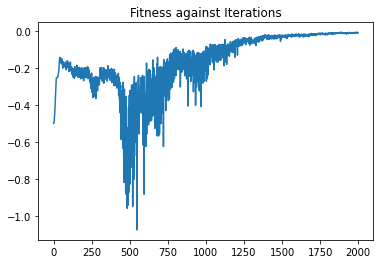

In [23]:
plt.plot(range(len(loss_ls)), loss_ls)
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [24]:
mse_ls[-1]

1.9150884e-05

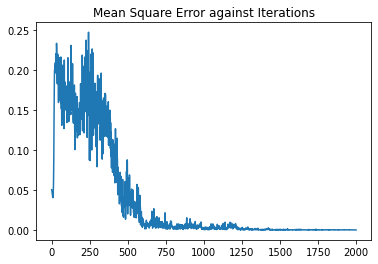

In [25]:
plt.plot(range(len(mse_ls)), mse_ls)
plt.title('Mean Square Error against Iterations')
plt.show()

# Compute the solution

In [26]:
## compare the two parameter dictionary, not sure why the
## one the policy produces places everything in one array
# policy._format_params_fn(best_params[None, :])
# hello = PINNs()
# params_hello = hello.init(random.PRNGKey(0), jnp.zeros([1,2]))

In [27]:
this_dict = policy._format_params_fn(best_params[None, :])
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
  # print(value1)
  for key2, value2 in value1.items():
    # print(value2)
    for key3, value3 in value2.items():
      new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [28]:
x = jnp.linspace(x_l, x_u, n)
data_pde = jnp.hstack([x.reshape(-1, 1), np.ones((len(x), 1))])
labels_pde = np.reshape(eval_u(x, Pe, L),(-1, 1))
hello = PINNs()
# params_hello = hello.init(random.PRNGKey(0), jnp.zeros([1,2]))
prediction = hello.apply(new_dict, data_pde)
u, u_x, u_xx = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3]

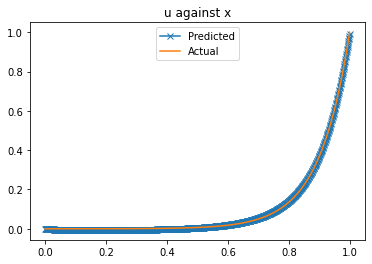

In [29]:
plt.plot(x, u, label = "Predicted", marker = "x")
plt.plot(x, labels_pde, label = "Actual")
leg = plt.legend(loc='upper center')
plt.title('u against x')
plt.show()